<a href="https://colab.research.google.com/github/Bone-Age-Maisha/paper_1/blob/main/Transfer%2BGadcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt


In [ ]:
IMG_SIZE = [224, 224]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
vgg = VGG16(input_shape=IMG_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(vgg.output)

In [ ]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

**DATA_PREP**

In [ ]:
import pandas as pd
train_dir = '/content/drive/MyDrive/RSNA/archive'
train_df = pd.read_csv('/content/drive/MyDrive/RSNA/archive/boneage-training-dataset.csv')

In [ ]:
import os
age_df = train_df 
age_df['path'] = age_df['id'].map(lambda x: os.path.join(train_dir,
                                                         'boneage-training-dataset', 
                                                         'boneage-training-dataset', 
                                                         '{}.png'.format(x)))
age_df['exists'] = age_df['path'].map(os.path.exists)
print(age_df['exists'].sum(), 'images found of', age_df.shape[0], 'total')
age_df['gender'] = age_df['male'].map(lambda x: 'male' if x else 'female')
boneage_mean = age_df['boneage'].mean()
boneage_div = 2*age_df['boneage'].std()
age_df['boneage_zscore'] = age_df['boneage'].map(lambda x: (x-boneage_mean)/boneage_div)
age_df.dropna(inplace = True)
age_df.sample(3)

12611 images found of 12611 total


,id,boneage,male,path,exists,gender,boneage_zscore
8947,11523,144,False,/content/drive/MyDrive/RSNA/archive/boneage-tr...,True,female,0.202506
2551,4212,132,False,/content/drive/MyDrive/RSNA/archive/boneage-tr...,True,female,0.056812
8891,11454,156,True,/content/drive/MyDrive/RSNA/archive/boneage-tr...,True,male,0.348201


New Data Size: 8000 Old Size: 12611


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb1a6781850>]],
      dtype=object)

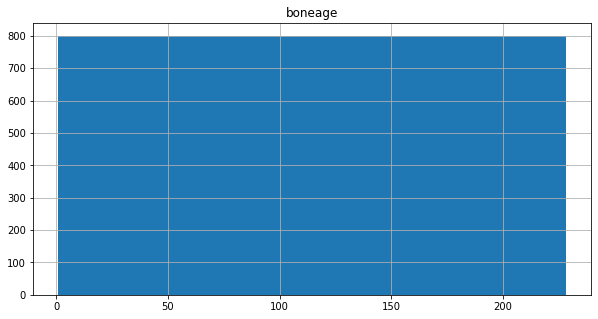

In [ ]:
age_df['boneage_category'] = pd.cut(age_df['boneage'], 10)
new_age_df = age_df.groupby(['boneage_category', 'male']).apply(lambda x: x.sample(400, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', new_age_df.shape[0], 'Old Size:', age_df.shape[0])
new_age_df[['boneage', 'male']].hist(figsize = (10, 5))

In [ ]:
from sklearn.model_selection import train_test_split

train_df,test_df = train_test_split(
                                                     new_age_df, 
                                   test_size = 0.2, 
                                   random_state = 2018,
                                   stratify = new_age_df['boneage_category'])

train_df, valid_df= train_test_split(
                                                   new_age_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = new_age_df['boneage_category'])
print('train', train_df.shape[0], 'validation', valid_df.shape[0] , 'test', test_df.shape[0])

train 6000 validation 2000 test 1600


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
#IMG_SIZE = (256, 256)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.1, 
                              width_shift_range = 0.1, 
                              rotation_range = 10, 
                              shear_range = 0.05,
                              fill_mode = 'nearest',
                              zoom_range=0.15)

In [ ]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.filepaths.extend(df_gen.filenames)
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' 
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [ ]:
train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'boneage_zscore', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 64)

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 6000 images


In [ ]:
t_x, t_y = next(train_gen)

In [ ]:
valid_gen = flow_from_dataframe(core_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'boneage_zscore', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 64) 

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 2000 images


In [ ]:
test_gen = flow_from_dataframe(core_idg, 
                              test_df, 
                             path_col = 'path',
                            y_col = 'boneage_zscore', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 500)

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 1600 images


In [ ]:
test_X, test_Y = next(test_gen)

In [ ]:
from keras.metrics import mean_absolute_error
def mae_months(in_gt, in_pred):
    return mean_absolute_error(boneage_div*in_gt, boneage_div*in_pred)

In [ ]:

#x = Dense(10, activation = 'relu')(x)
out_layer = Dense(1, activation = 'linear')(x)
model = Model(inputs=vgg.input, outputs=out_layer )
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model.compile(loss ='mse', optimizer= 'adam', metrics = [mae_months] )

In [ ]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint



checkpoint = ModelCheckpoint(filepath='mymodel.h5', 
                               verbose=2, save_best_only=True)

callbacks = [checkpoint]

start = datetime.now()

model_history=model.fit_generator(
  train_gen,
  validation_data=(test_X,test_Y),
  epochs=2,
  steps_per_epoch=5,
  validation_steps=32,
    callbacks=callbacks ,verbose=2)


duration = datetime.now() - start
print("Training completed in time: ", duration)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/2

Epoch 1: val_loss improved from inf to 4.93791, saving model to mymodel.h5
5/5 - 424s - loss: 6.5572 - mae_months: 178.5653 - val_loss: 4.9379 - val_mae_months: 171.2012 - 424s/epoch - 85s/step
Epoch 2/2

Epoch 2: val_loss improved from 4.93791 to 3.36683, saving model to mymodel.h5
5/5 - 470s - loss: 3.3890 - mae_months: 131.8786 - val_loss: 3.3668 - val_mae_months: 141.8946 - 470s/epoch - 94s/step
Training completed in time:  0:14:57.967147


/content/drive/MyDrive/RSNA/archive/boneage-training-dataset/boneage-training-dataset/11328.png


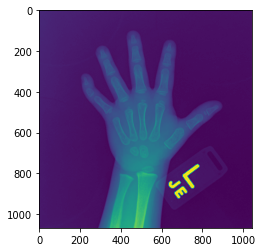

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt



last_conv_layer_name = "block5_conv3"


for column in train_df['path']:
  print(column)
  img = mpimg.imread(column)
  plt.imshow(img)
  break


In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]


    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

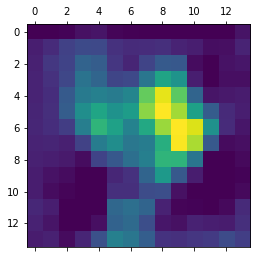

In [ ]:
import keras
import tensorflow as tf
preprocess_input = keras.applications.xception.preprocess_input
img_path="/content/drive/MyDrive/RSNA/archive/boneage-training-dataset/boneage-training-dataset/11328.png"
img_array = preprocess_input(get_img_array(img_path, size=IMG_SIZE))


# Print what the top predicted class is
preds = model.predict(img_array)
#print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

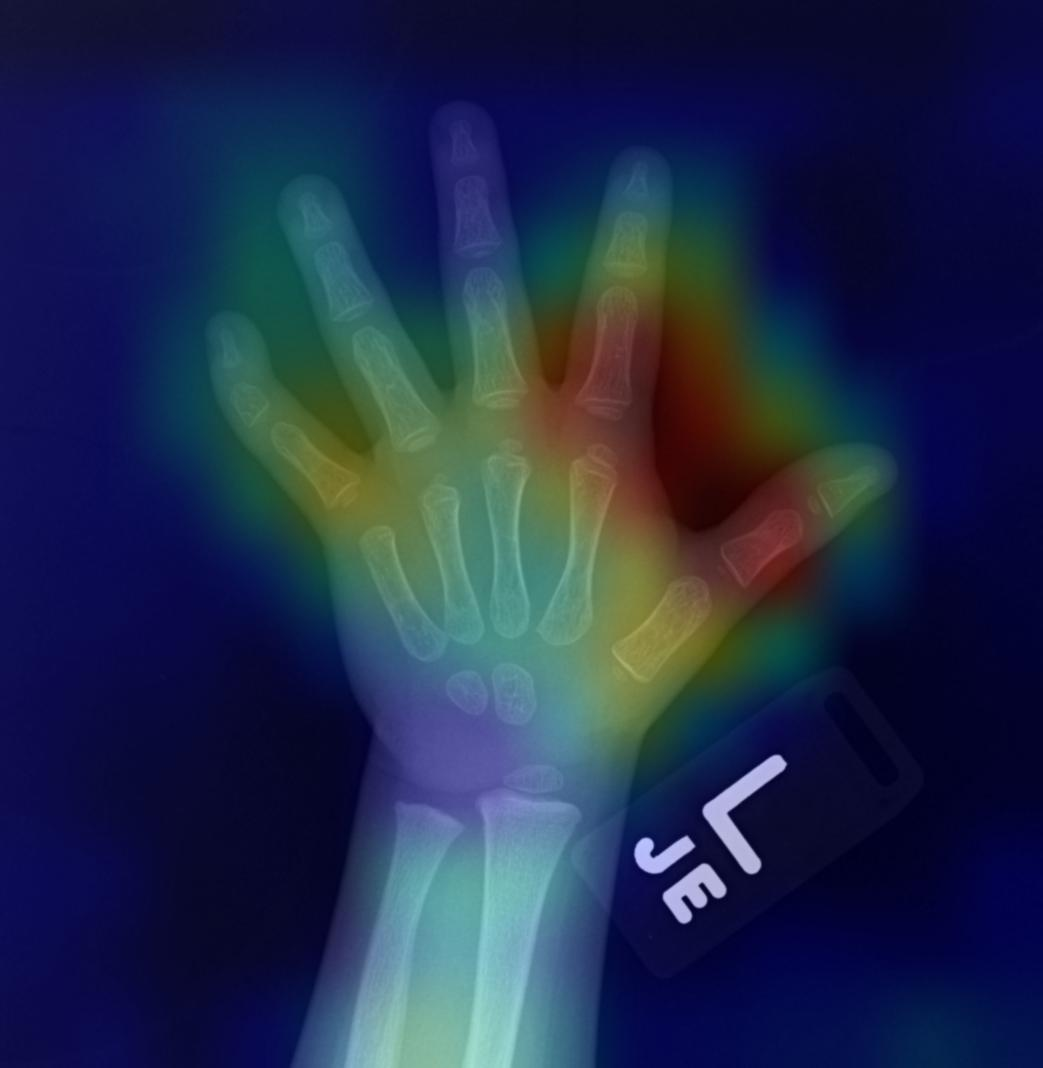

In [ ]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))
save_and_display_gradcam(img_path, heatmap)